In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [14]:
chars = sorted(set(''.join(words)))
stoi = {c: i + 1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [7]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for char in word + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
embedding_dimension = 10
hidden_dimension = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_dimension), generator=g)
W1 = torch.randn((block_size * embedding_dimension, hidden_dimension), generator=g)
b1 = torch.randn(hidden_dimension, generator=g)
W2 = torch.randn((hidden_dimension, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [10]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    embedding = C[Xb] # embed characters into vectors
    embedding_cat = embedding.view(embedding.shape[0], -1) # concat the vectors
    hpreact = embedding_cat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # logits
    loss = F.cross_entropy(logits, Yb) # loss

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'iteration {i}, loss: {loss.item()}')
    
    lossi.append(loss.log10().item())


iteration 0, loss: 28.385374069213867
iteration 1000, loss: 3.9576640129089355
iteration 2000, loss: 3.2865092754364014
iteration 3000, loss: 3.3476920127868652
iteration 4000, loss: 2.872255325317383
iteration 5000, loss: 2.592484712600708
iteration 6000, loss: 2.8010895252227783
iteration 7000, loss: 2.637843608856201
iteration 8000, loss: 2.4824838638305664
iteration 9000, loss: 2.711625576019287
iteration 10000, loss: 2.8554019927978516
iteration 11000, loss: 2.6271140575408936
iteration 12000, loss: 2.4403536319732666
iteration 13000, loss: 2.3063626289367676
iteration 14000, loss: 2.592794895172119
iteration 15000, loss: 2.0433576107025146
iteration 16000, loss: 2.100594997406006
iteration 17000, loss: 2.488523244857788
iteration 18000, loss: 2.2710230350494385
iteration 19000, loss: 2.505108594894409
iteration 20000, loss: 2.8137073516845703
iteration 21000, loss: 2.370631217956543
iteration 22000, loss: 2.275012254714966
iteration 23000, loss: 2.5766079425811768
iteration 24000

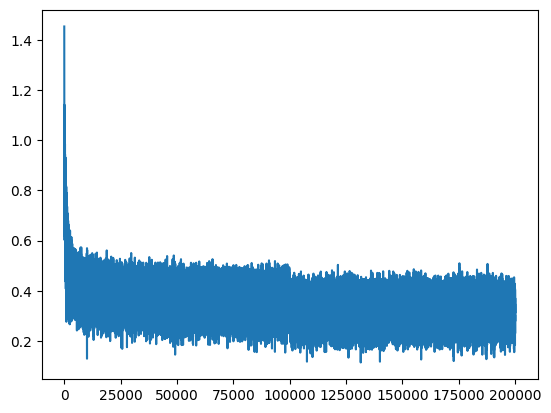

In [15]:
plt.plot(lossi)

In [12]:
@torch.no_grad() # no need to track gradients in the test phase
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xva, Yva),
        'test': (Xte, Yte)
    }[split]
    embedding = C[x] # )N, block_size, embedding_dimension)
    embedding_cat = embedding.view(embedding.shape[0], -1) # concat into (N, block_size * embedding_dimension)
    h = torch.tanh(embedding_cat @ W1 + b1) # (N, hidden_dimension)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1207988262176514
val 2.1562674045562744


In [17]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
medhayla.
remmadiendraj.
cadered.
elin.
shy.
jen.
eden.
estanaraelyn.
malaia.
nyshubergiaghiel.
janie.
jeyvonnie.
casuna.
ted.
ryyah.
faeha.
kayjahshouda.
